Import libraries 

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from xgboost import XGBRegressor, plot_importance 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import linregress 

Load the data 

In [6]:
# Load the Excel file into a DataFrame 
file_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
df = pd.read_csv(file_path) 
df = df.drop('BMI',axis =1) 
print(df.shape) 

# Remove rows with missing values 
df['Education'].replace(' ', np.nan, inplace=True) 
df['Weight'].replace(' ', np.nan, inplace=True) 
df['Height'].replace(' ', np.nan, inplace=True) 

# df['BMI'].replace(' ', np.nan, inplace=True) 
df['Waist'].replace(' ', np.nan, inplace=True) 
df['Ethnicity'].replace(' ', np.nan, inplace=True) 
df['Age'].replace(' ', np.nan, inplace=True) 
df['Gender'].replace(' ', np.nan, inplace=True) 
df.dropna(inplace=True) 

df['Weight'] = df['Weight'].astype(float)
df['Height'] = df['Height'].astype(float)
df['Waist'] = df['Waist'].astype(float)
df['Education'] = df['Education'].astype(float)
    
# Separate the data based on Gender (1 and 2) 
df_gender_1 = df[df['Gender'] == 1] 
df_gender_1 = df_gender_1.drop(columns=['Gender']) 
df_gender_2 = df[df['Gender'] == 2] 
df_gender_2 = df_gender_2.drop(columns=['Gender']) 
print(df.shape,df_gender_1.shape,df_gender_2.shape) 

df.head() 
df.info() 

(45377, 8)
(38493, 8) (19080, 7) (19413, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 38493 entries, 0 to 45376
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       38493 non-null  int64  
 1   Gender     38493 non-null  int64  
 2   Age        38493 non-null  int64  
 3   Ethnicity  38493 non-null  int64  
 4   Education  38493 non-null  float64
 5   Weight     38493 non-null  float64
 6   Height     38493 non-null  float64
 7   Waist      38493 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 2.6 MB


Useful functions 

/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is

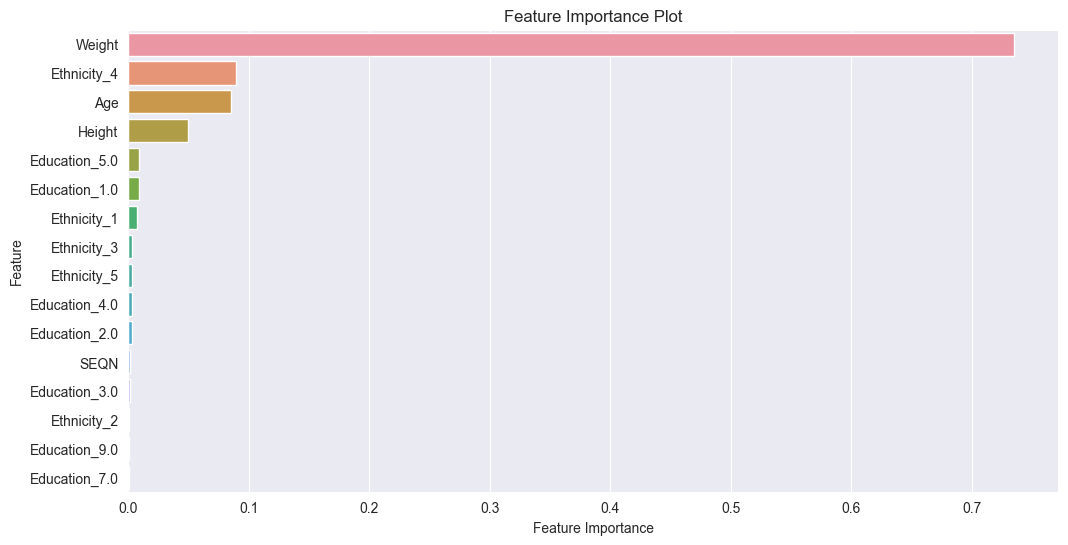

Gender 1 - RMSE: 4.333655011016748


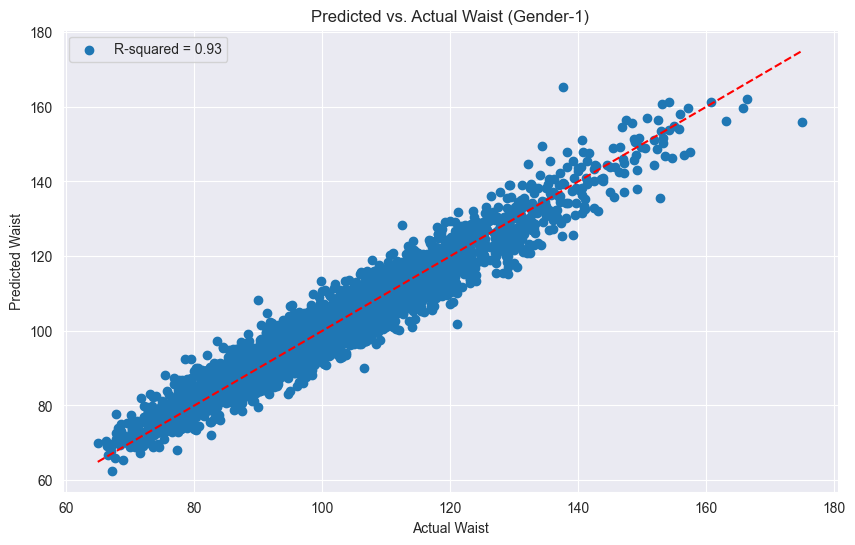

In [7]:
# Define a function to preprocess the data 
def preprocess_data(data): 
    # Encode categorical variables (Education and Ethnicity) using one-hot encoding 
    data = pd.get_dummies(data, columns=['Education', 'Ethnicity']) 
    
    # Split the data into features (X) and target (y) 
    X = data.drop(columns=['Waist']) 
    y = data['Waist'] 
    return X, y 

# Preprocess data for Gender 1 
X_gender_1, y_gender_1 = preprocess_data(df_gender_1) 
# Preprocess data for Gender 2 
X_gender_2, y_gender_2 = preprocess_data(df_gender_2) 

# Function to train and evaluate an XGBoost model with hyperparameter tuning 
def train_xgboost_model(X, y): 
    # Split the data into training and testing sets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    # Create an XGBoost regressor 
    xgb = XGBRegressor(random_state=42) 
    # Hyperparameter tuning using GridSearchCV 
    param_grid = { 
        'n_estimators': [100, 200, 300], 
        'max_depth': [3, 4, 5], 
        'learning_rate': [0.1, 0.01, 0.001] 
    } 

    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5) 
    grid_search.fit(X_train, y_train) 

    # Get the best estimator 
    best_xgb = grid_search.best_estimator_ 

    # Cross-validation 
    cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error') 
    rmse_scores = np.sqrt(-cv_scores) 

    # Train the model on the entire training set 
    best_xgb.fit(X_train, y_train) 

    # Predict on the test set 
    y_pred = best_xgb.predict(X_test) 

    # Compute feature importance 
    feature_importance = best_xgb.feature_importances_ 
    feature_names = X.columns 
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}) 
    importance_df = importance_df.sort_values(by='Importance', ascending=False) 

    # Plot feature importance 
    plt.figure(figsize=(12, 6)) 
    sns.barplot(x='Importance', y='Feature', data=importance_df) 
    plt.xlabel("Feature Importance") 
    plt.ylabel("Feature") 
    plt.title("Feature Importance Plot") 
    plt.show() 
    return y_pred, y_test, best_xgb, np.mean(rmse_scores) 

# Train and evaluate the models for Gender 1 and Gender 2 
y_pred_1, y_test_1, best_xgb_gender_1, rmse_gender_1 = train_xgboost_model(X_gender_1, y_gender_1) 
print("Gender 1 - RMSE:", rmse_gender_1) 
 
# Calculate the R-squared value 
slope, intercept, r_value, p_value, std_err = linregress(y_test_1, y_pred_1) 
r_squared = r_value ** 2 

# Plot the scatter plot and line of best fit 
plt.figure(figsize=(10, 6)) 
plt.scatter(y_test_1, y_pred_1, label=f'R-squared = {r_squared:.2f}') 
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], linestyle='--', color='red') 
plt.xlabel("Actual Waist") 
plt.ylabel("Predicted Waist") 
plt.title(f"Predicted vs. Actual Waist (Gender-1)") 
plt.legend() 
plt.show() 

For gender-2 

/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is

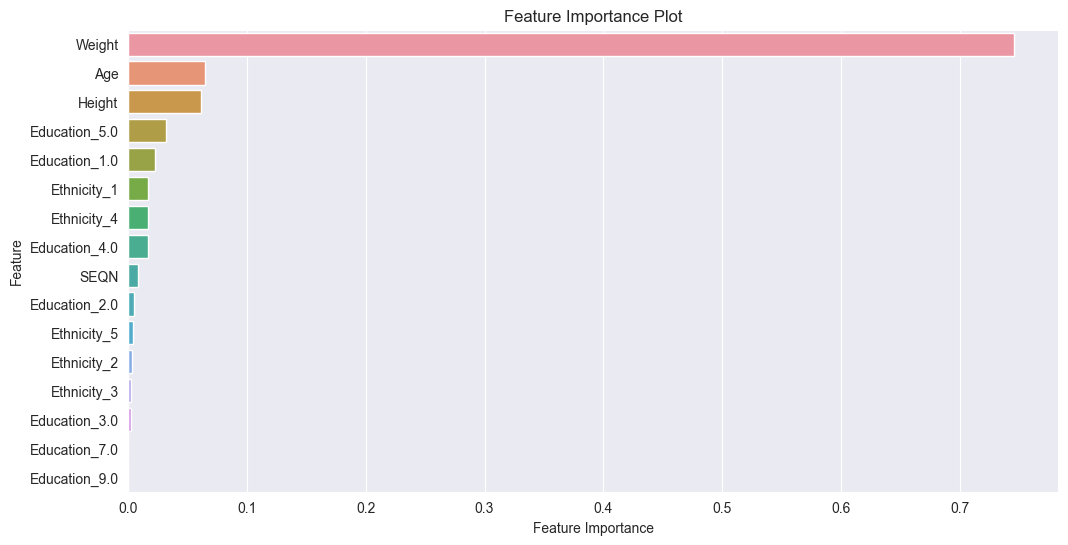

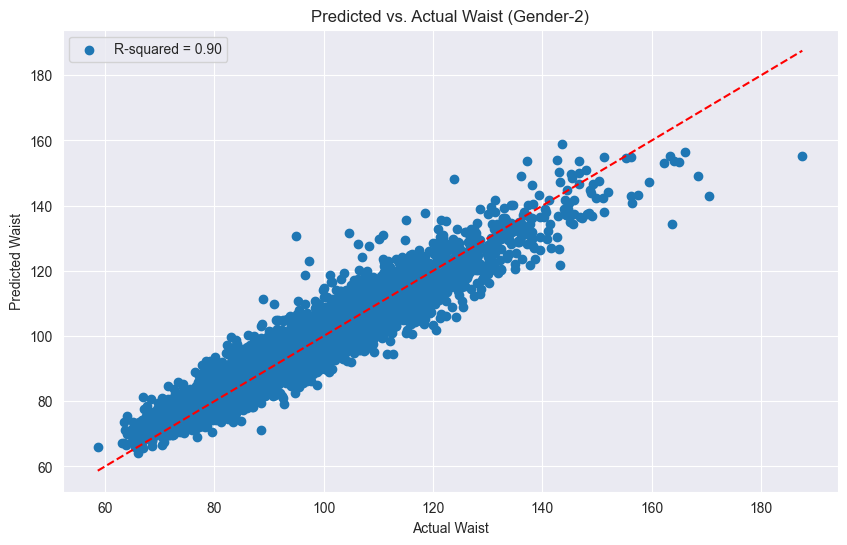

Gender 2 - RMSE: 5.535924967475075


In [8]:
y_pred_2, y_test_2, best_xgb_gender_2, rmse_gender_2 = train_xgboost_model(X_gender_2, y_gender_2) 

# Calculate the R-squared value 
slope, intercept, r_value, p_value, std_err = linregress(y_test_2, y_pred_2) 
r_squared = r_value ** 2 

# Plot the scatter plot and line of best fit 
plt.figure(figsize=(10, 6)) 
plt.scatter(y_test_2, y_pred_2, label=f'R-squared = {r_squared:.2f}') 
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], linestyle='--', color='red') 
plt.xlabel("Actual Waist") 
plt.ylabel("Predicted Waist") 
plt.title(f"Predicted vs. Actual Waist (Gender-2)") 
plt.legend() 
plt.show() 
print("Gender 2 - RMSE:", rmse_gender_2) 